In [1]:
from sklearn.metrics import confusion_matrix, auc, accuracy_score
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import xgboost as xgb

In [2]:
`from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# 設定繪圖
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [4]:
def detect_str_columns(data):
    '''
    1. 偵測有字串的欄位
    2. 挑選出來，準備encoding
    
    '''
    strlist = list(set(np.where((data.applymap(type)==str))[1].tolist()))
    return data.columns[strlist].tolist()

def get_dummies(dummy, dataset):
    ''''
    make variables dummies 啞變量
    '''
    dummy_fields = list(dummy)
    for each in dummy_fields:
        dummies = pd.get_dummies( dataset.loc[:, each], prefix=each ) 
        dataset = pd.concat( [dataset, dummies], axis = 1 )
    
    fields_to_drop = dummy_fields
    dataset = dataset.drop( fields_to_drop, axis = 1 )
    return dataset

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     fig.savefig(title+'.png', dpi=300)

In [6]:
def model(clf, X_train,y_train,X_test,y_test,
                    plot_name = 'logistic_regression') :
    model = clf.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_test_df=pd.DataFrame(y_test)
    y_test_df[plot_name+'_pred'] = y_pred_prob
    #Confusion Matrix
    conf_logist = confusion_matrix(y_test, y_pred)
    
    feat_imp = model.feature_importances_
    feat = X_train.columns.tolist()
    res_data = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=True)
#     res_data.plot('Features', 'Importance', kind='barh', title='變數重要性長條圖',stacked=True, figsize = (15,10))
#     plt.ylabel(plot_name+' Feature Importance Score')
#     plt.savefig(plot_name+'.png', dpi=300)
#     plt.show()
    
    
    res_data = res_data.sort_values('Importance',ascending=False)
    
    # > 50%
    res_data = res_data[res_data['Importance']>res_data['Importance'].describe()['50%']]
    

    print( "################ summary ################ ")
    plot_confusion_matrix(conf_logist, ['no','Exited'],
                  title=plot_name+"Confusion Matrix plot", cmap=plt.cm.Reds)#, cmap=plt.cm.Reds
    print(confusion_matrix(y_test, y_pred))
    print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
    print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
    
    
    # importance
    print( '------------------ 應注意之變數 ------------------' )
                    
    print(res_data)
    
    print( '------------------' +plot_name+ '重要變數表------------------' )
#     res_data.to_excel(plot_name+'重要變數表.xlsx')
    
    
    return res_data, y_test_df

In [7]:
data = pd.read_csv('C:\Python 3.6\sample\\train.csv')
data = data.drop(columns=['Balance', 'RowNumber', 'CustomerId', 'Surname', 'Unnamed: 0'])
str_columns = detect_str_columns(data)
datasat = get_dummies(str_columns, data)
datasat.info()
X = datasat.drop(columns=['Exited'])
y = datasat['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 13 columns):
CreditScore        8000 non-null int64
Age                8000 non-null int64
Tenure             8000 non-null int64
NumOfProducts      8000 non-null int64
HasCrCard          8000 non-null int64
IsActiveMember     8000 non-null int64
EstimatedSalary    8000 non-null float64
Exited             8000 non-null int64
Geography_S0       8000 non-null uint8
Geography_S1       8000 non-null uint8
Geography_S2       8000 non-null uint8
Gender_Female      8000 non-null uint8
Gender_Male        8000 non-null uint8
dtypes: float64(1), int64(7), uint8(5)
memory usage: 539.1 KB


In [8]:
test = pd.read_csv('C:\Python 3.6\sample\\test.csv')
test_data = test.drop(columns=['Balance', 'RowNumber', 'CustomerId', 'Surname', 'Unnamed: 0'])

str_columns_t = detect_str_columns(test_data)
test_datasat = get_dummies(str_columns_t, test_data)
# test_data
test_datasat.info()
X_test_pred = test_datasat
# y_test_pred = test_datasat['Exited']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
CreditScore        2000 non-null int64
Age                2000 non-null int64
Tenure             2000 non-null int64
NumOfProducts      2000 non-null int64
HasCrCard          2000 non-null int64
IsActiveMember     2000 non-null int64
EstimatedSalary    2000 non-null float64
Geography_S0       2000 non-null uint8
Geography_S1       2000 non-null uint8
Geography_S2       2000 non-null uint8
Gender_Female      2000 non-null uint8
Gender_Male        2000 non-null uint8
dtypes: float64(1), int64(6), uint8(5)
memory usage: 119.2 KB


################ summary ################ 
Confusion matrix, without normalization
[[1229   41]
 [ 183  147]]
Training Accuracy = 0.864
Test Accuracy = 0.860
------------------ 應注意之變數 ------------------
          Features  Importance
1              Age    0.220114
5   IsActiveMember    0.207781
3    NumOfProducts    0.206662
8     Geography_S1    0.143578
10   Gender_Female    0.068033
9     Geography_S2    0.036516
------------------xgboost重要變數表------------------


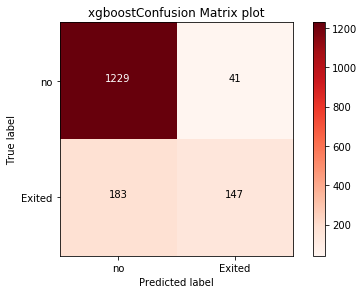

In [9]:
res_data, xgboost_y_test_df = model(
        clf = XGBClassifier(n_estimators = 50, random_state = 0, nthread = 8),
        X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test,
        plot_name = 'xgboost'
        )

In [10]:
clf = XGBClassifier(n_estimators = 200, random_state = 0, nthread = 8)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test_pred)
y_pred.shape

(2000,)

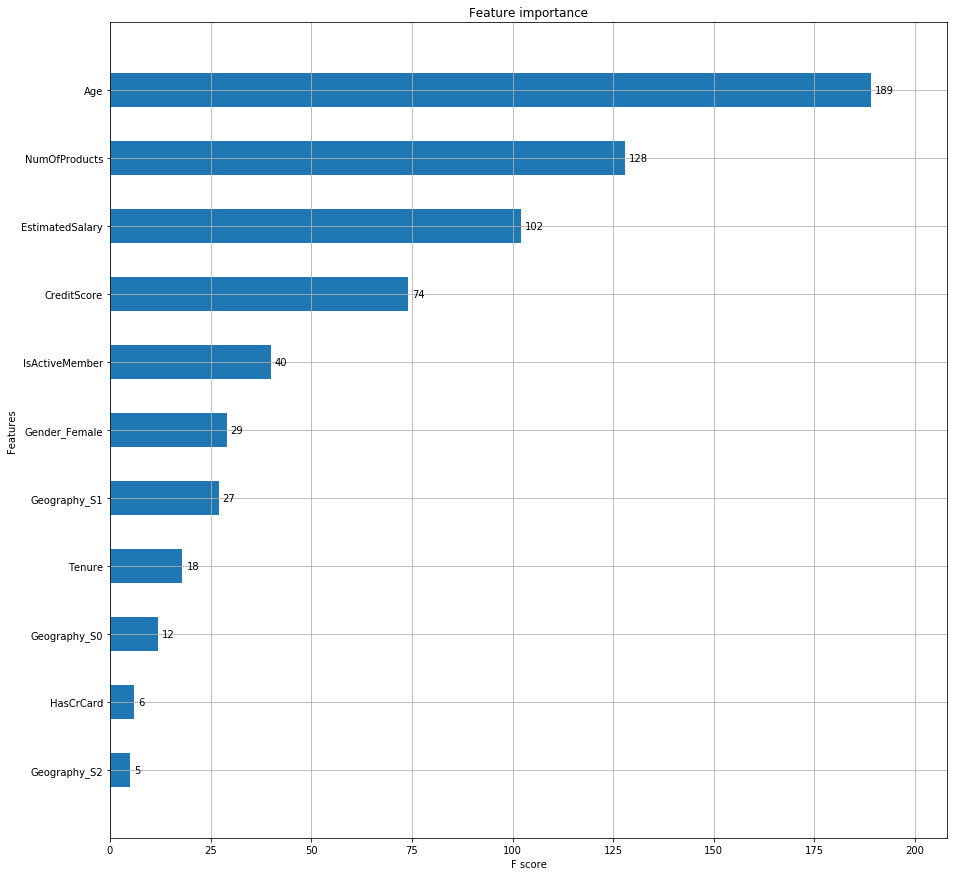

In [11]:
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X_train,y_train)

### plot feature importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

In [12]:
pred = pd.DataFrame(columns=['RowNumber', 'Exited'])
pred['RowNumber'] = test['RowNumber']
pred['Exited'] = y_pred
path = 'C:\Python 3.6\sample\\predict_n5.csv'
pred.to_csv(path, mode='w', index=True)